In [1]:
import numpy as np
import pandas as pd

import time
from datetime import datetime

import gensim
import matplotlib.pyplot as plt

import en_nlp_utils
import model_evaluation_utils

In [2]:
# Define default source path
SRC_PATH = "src/"

start_time = datetime.now()
print("Text processing started at {}".format(start_time))

Text processing started at 2024-06-26 20:50:47.439094


In [3]:
# Load dataset
df_review = pd.read_csv(SRC_PATH + "en_hotel_review.csv")

In [4]:
# Check NULL values
en_nlp_utils.check_null(df_review, "df_review")

# Remove rows when "review_cleaned_v1" is NULL
df_review = df_review.dropna(subset=["review_cleaned_v1"]).reset_index(drop=True)

df_review:
source                     0
hotel_id                   0
hotel_name                 0
country                    0
group_name                 0
room_type                  0
stay_length                0
stay_date                  0
review_score               0
review_score_category      0
sentiment                  0
review_date                0
review_title               1
review                     0
review_cleaned_v1        143
dtype: int64
Total rows in df_review: 39974 



## 1) Applying Stratified Sampling

In [5]:
# Function for stratified sampling
def stratified_sample(df, stratify_col, frac):
    return df.groupby(stratify_col, group_keys=False).apply(lambda x: x.sample(frac=frac))

# Convert "stay_date" and "review_date" columns as datetime data type
df_review["stay_date"] = pd.to_datetime(df_review["stay_date"], format="%d/%m/%Y")

# Stratified sampling based on year and sentiment
frac = 0.30  # Sampling ratio
sampled_2022 = stratified_sample(df_review[df_review["stay_date"].dt.year == 2022], "sentiment", frac)
sampled_2023 = stratified_sample(df_review[df_review["stay_date"].dt.year == 2023], "sentiment", frac)
sampled_2024 = stratified_sample(df_review[df_review["stay_date"].dt.year == 2024], "sentiment", frac)

# Merge the sampled data
sampled_data = pd.concat([sampled_2022, sampled_2023, sampled_2024])

In [6]:
# Count number of reviews based on year and sentiment
sampled_sentiment_count = sampled_data.groupby([sampled_data["sentiment"], sampled_data["stay_date"].dt.year]).size().reset_index(name="count")
sampled_sentiment_count2 = sampled_sentiment_count.pivot_table(index="stay_date", columns="sentiment", values="count", 
                                               aggfunc="sum", margins=True, margins_name="Total")
sampled_sentiment_count2.columns.name = None
sampled_sentiment_count2

,negative,positive,Total
stay_date,,,
2022,507,1668,2175
2023,1609,6412,8021
2024,330,1422,1752
Total,2446,9502,11948


## 2) Topic Modeling

### a) Helper functions

In [7]:
# Function to generate bow corpus
def generate_bow_corpus(df, target_text):
    
    documents = [en_nlp_utils.tokenize_sentence_to_words(cleaned_review) for cleaned_review in df[target_text]]
    
    bigram = gensim.models.Phrases(documents, min_count=20, threshold=20, delimiter="_") # higher threshold fewer phrases.
    bigram_model = gensim.models.phrases.Phraser(bigram)
    
    corpus_bigrams = [bigram_model[doc] for doc in documents]
    dictionary = gensim.corpora.Dictionary(corpus_bigrams)
    dictionary.filter_extremes(no_below=20, no_above=0.6)
    bow_corpus = [dictionary.doc2bow(text) for text in corpus_bigrams]
    
    return bow_corpus, corpus_bigrams, dictionary


# Function to calculate all models' coherence scores
def topic_model_coherence_plot(df, df_name, target_text, MODEL_NAMES, START_TOPIC_COUNT, END_TOPIC_COUNT):
    
    overall_coherence_df = pd.DataFrame() # Store each model's coherence scores
    model_topic_info = [] # Store each model's topic information
    
    bow_corpus, corpus_bigrams, dictionary = generate_bow_corpus(df, target_text)
    model_count = 0
    
    for MODEL_NAME in MODEL_NAMES:
        models, coherence_scores = en_nlp_utils.topic_model_coherence_generator(model_name=MODEL_NAME,
                                                                                corpus=bow_corpus,
                                                                                texts=corpus_bigrams,
                                                                                dictionary=dictionary,
                                                                                start_topic_count=START_TOPIC_COUNT,
                                                                                end_topic_count=END_TOPIC_COUNT,
                                                                                step=1,
                                                                                cpus=-1,
                                                                                print_topics=True)

        coherence_df = pd.DataFrame({"Model Name": MODEL_NAME, 
                                     "Number of Topics": range(START_TOPIC_COUNT, END_TOPIC_COUNT + 1, 1), 
                                     "Coherence Score": np.round(coherence_scores, 6),
                                     "df_name": df_name})
        coherence_df.sort_values(by=["Coherence Score"], ascending=False)
        print(coherence_df)
        
        overall_coherence_df = pd.concat([overall_coherence_df, coherence_df], axis=0)
        
        model_topics = []
        for model in models:
            num_topics = model.num_topics
            topics = [[(term, round(wt, 3)) for term, wt in model.show_topic(n, topn=10)] for n in range(num_topics)]
            
            # Determine the number of columns dynamically
            num_terms_per_topic = max(len(topic) for topic in topics)
            
            # Create a DataFrame for topics with dynamic columns and names
            topics_df = pd.DataFrame([[term if len(topic) > i else "" for i, (term, wt) in enumerate(topic)]
                                      for topic in topics],
                                     columns=[f"Term{i+1}" for i in range(num_terms_per_topic)],
                                     index=[f"Topic {t+1}" for t in range(num_topics)]).T
            
            model_topic_info.append({
                "Model Name": MODEL_NAME,
                "Number of Topics": num_topics,
                "Topics": topics_df.to_dict(orient="list"),  # Convert DataFrame to dictionary
                "df_name": df_name
            })
        
        x_ax = range(START_TOPIC_COUNT, END_TOPIC_COUNT + 1, 1)
        y_ax = coherence_scores
        plt.figure(num=model_count, figsize=(15, 12))
        plt.plot(x_ax, y_ax, c="r")
        plt.axhline(y=0.3, c="k", linestyle="--", linewidth=2)
        plt.axhline(y=0.4, c="k", linestyle="--", linewidth=2)
        plt.axhline(y=0.5, c="k", linestyle="--", linewidth=2)
        plt.rcParams["figure.facecolor"] = "white"
        xl = plt.xlabel("Number of Topics")
        yl = plt.ylabel("Coherence Score")

        model_count += 1

    plt.show()
    return overall_coherence_df, model_topic_info


# Function to print best model's topics
def print_best_model_topics(overall_coherence_best_df, model_topic_info_list):
    
    for index, row in overall_coherence_best_df.iterrows():
        model_name = row["Model Name"]
        num_topics = row["Number of Topics"]
        df_name = row["df_name"]
        
        print(f"\nDF NAME: {df_name}\nMODEL: {model_name} - NUMBER OF TOPICS: {num_topics}")
       
        # Find the corresponding model_topic_info
        for model_topic_info in model_topic_info_list:
            for model_info in model_topic_info:
                if (model_info["Model Name"] == model_name and
                    model_info["Number of Topics"] == num_topics and
                    model_info["df_name"] == df_name):
                    
                    topics = model_info["Topics"]
                    for topic_num, terms in topics.items():
                        print(f"\n{topic_num}: {', '.join(terms)}")
                        
                    print("\n----------\n")
                    break

### b) Topic Modeling

In [8]:
# Filter positive and negative reviews and save into different dataframe
df_pos = sampled_data[sampled_data["sentiment"] == "positive"].reset_index(drop=True)
df_neg = sampled_data[sampled_data["sentiment"] == "negative"].reset_index(drop=True)

In [9]:
MODEL_NAMES = ["LSI", "LDA"]
START_TOPIC_COUNT = 2
END_TOPIC_COUNT = 10

df_sets = [df_pos, df_neg]
df_names = ["df_pos", "df_neg"]


DF NAME: df_pos



  0%|                                                                                            | 0/9 [00:00<?, ?it/s]


MODEL: LSI - NUMBER OF TOPICS: 2


 11%|█████████▏                                                                         | 1/9 [02:56<23:28, 176.06s/it]

Topic #1:
0.527*"I" + 0.467*"room" + 0.343*"hotel" + 0.211*"stay" + 0.197*"staff" + 0.182*"good" + 0.146*"location" + 0.143*"clean" + 0.092*"check" + 0.087*"get" + 0.084*"great" + 0.077*"also" + 0.076*"small" + 0.074*"nice" + 0.070*"place" + 0.069*"book" + 0.069*"would" + 0.068*"time" + 0.067*"bed" + 0.067*"night"

Topic #2:
-0.785*"I" + 0.366*"room" + 0.235*"good" + 0.211*"location" + 0.162*"hotel" + 0.153*"clean" + 0.098*"great" + 0.088*"small" + 0.076*"staff" + 0.074*"nice" + 0.063*"friendly" + 0.059*"near" + 0.057*"meet" + -0.050*"check" + -0.047*"say" + 0.046*"stay" + -0.046*"ask" + 0.042*"close" + 0.041*"helpful" + -0.039*"tell"

--------------------------------------------------

MODEL: LSI - NUMBER OF TOPICS: 3


 22%|██████████████████▍                                                                | 2/9 [05:43<19:55, 170.82s/it]

Topic #1:
0.527*"I" + 0.467*"room" + 0.342*"hotel" + 0.211*"stay" + 0.197*"staff" + 0.183*"good" + 0.146*"location" + 0.143*"clean" + 0.092*"check" + 0.088*"get" + 0.084*"great" + 0.077*"also" + 0.076*"small" + 0.074*"nice" + 0.070*"place" + 0.069*"book" + 0.069*"would" + 0.068*"time" + 0.067*"bed" + 0.067*"night"

Topic #2:
-0.785*"I" + 0.360*"room" + 0.237*"good" + 0.213*"location" + 0.165*"hotel" + 0.153*"clean" + 0.099*"great" + 0.087*"small" + 0.078*"staff" + 0.074*"nice" + 0.064*"friendly" + 0.059*"near" + 0.057*"meet" + -0.051*"check" + -0.048*"say" + 0.047*"stay" + -0.046*"ask" + 0.042*"close" + 0.041*"helpful" + -0.039*"tell"

Topic #3:
-0.685*"room" + 0.585*"hotel" + 0.193*"good" + 0.171*"location" + 0.131*"staff" + 0.122*"stay" + 0.082*"great" + -0.073*"small" + 0.072*"friendly" + 0.061*"singapore" + 0.058*"place" + 0.058*"near" + 0.053*"meet" + -0.048*"bed" + 0.046*"helpful" + 0.045*"food" + 0.038*"nice" + -0.037*"clean" + 0.036*"meet_station" + -0.035*"check"

------------

 33%|███████████████████████████▋                                                       | 3/9 [08:30<16:54, 169.01s/it]

Topic #1:
0.527*"I" + 0.466*"room" + 0.342*"hotel" + 0.211*"stay" + 0.197*"staff" + 0.183*"good" + 0.146*"location" + 0.143*"clean" + 0.092*"check" + 0.088*"get" + 0.084*"great" + 0.077*"also" + 0.076*"small" + 0.074*"nice" + 0.070*"place" + 0.069*"would" + 0.069*"book" + 0.068*"time" + 0.067*"bed" + 0.067*"night"

Topic #2:
-0.786*"I" + 0.359*"room" + 0.238*"good" + 0.212*"location" + 0.166*"hotel" + 0.153*"clean" + 0.098*"great" + 0.087*"small" + 0.079*"staff" + 0.074*"nice" + 0.065*"friendly" + 0.059*"near" + 0.057*"meet" + -0.050*"check" + -0.047*"say" + 0.047*"stay" + -0.046*"ask" + 0.042*"close" + 0.041*"helpful" + -0.039*"tell"

Topic #3:
-0.689*"room" + 0.572*"hotel" + 0.202*"good" + 0.178*"location" + 0.143*"staff" + 0.119*"stay" + 0.083*"great" + 0.077*"friendly" + -0.074*"small" + 0.060*"place" + 0.058*"singapore" + 0.057*"near" + 0.053*"meet" + 0.050*"helpful" + -0.050*"bed" + 0.046*"food" + 0.041*"nice" + -0.038*"check" + -0.036*"book" + 0.036*"meet_station"

Topic #4:
0.6

 44%|████████████████████████████████████▉                                              | 4/9 [11:36<14:39, 175.98s/it]

Topic #1:
0.527*"I" + 0.466*"room" + 0.342*"hotel" + 0.211*"stay" + 0.197*"staff" + 0.184*"good" + 0.147*"location" + 0.143*"clean" + 0.092*"check" + 0.088*"get" + 0.084*"great" + 0.077*"also" + 0.076*"small" + 0.074*"nice" + 0.070*"place" + 0.069*"book" + 0.069*"would" + 0.068*"time" + 0.067*"bed" + 0.067*"night"

Topic #2:
-0.787*"I" + 0.357*"room" + 0.236*"good" + 0.212*"location" + 0.167*"hotel" + 0.153*"clean" + 0.099*"great" + 0.086*"small" + 0.082*"staff" + 0.075*"nice" + 0.065*"friendly" + 0.059*"near" + 0.058*"meet" + -0.048*"check" + 0.048*"stay" + -0.047*"say" + -0.046*"ask" + 0.043*"close" + 0.042*"helpful" + -0.039*"tell"

Topic #3:
-0.689*"room" + 0.575*"hotel" + 0.216*"good" + 0.178*"location" + 0.131*"staff" + 0.104*"stay" + 0.078*"great" + -0.072*"small" + 0.071*"friendly" + 0.060*"place" + 0.059*"near" + 0.058*"singapore" + 0.055*"meet" + -0.049*"bed" + 0.048*"food" + 0.046*"helpful" + 0.041*"nice" + -0.038*"check" + -0.036*"clean" + -0.035*"book"

Topic #4:
0.656*"ho

 56%|██████████████████████████████████████████████                                     | 5/9 [14:57<12:19, 184.76s/it]

Topic #1:
0.527*"I" + 0.466*"room" + 0.342*"hotel" + 0.211*"stay" + 0.197*"staff" + 0.183*"good" + 0.147*"location" + 0.143*"clean" + 0.092*"check" + 0.088*"get" + 0.084*"great" + 0.077*"also" + 0.076*"small" + 0.074*"nice" + 0.070*"place" + 0.069*"would" + 0.069*"book" + 0.068*"time" + 0.067*"bed" + 0.067*"night"

Topic #2:
-0.786*"I" + 0.360*"room" + 0.239*"good" + 0.211*"location" + 0.168*"hotel" + 0.151*"clean" + 0.098*"great" + 0.086*"small" + 0.080*"staff" + 0.073*"nice" + 0.064*"friendly" + 0.059*"near" + 0.057*"meet" + -0.048*"check" + 0.048*"stay" + -0.047*"say" + -0.045*"ask" + 0.043*"close" + 0.041*"helpful" + -0.038*"tell"

Topic #3:
-0.689*"room" + 0.578*"hotel" + 0.208*"good" + 0.176*"location" + 0.124*"staff" + 0.112*"stay" + 0.079*"great" + -0.072*"small" + 0.070*"friendly" + 0.064*"place" + 0.060*"near" + 0.060*"singapore" + 0.055*"meet" + -0.048*"bed" + 0.048*"food" + 0.045*"helpful" + 0.041*"nice" + -0.039*"check" + 0.036*"meet_station" + -0.036*"book"

Topic #4:
0.6

 67%|███████████████████████████████████████████████████████▎                           | 6/9 [17:52<09:04, 181.55s/it]

Topic #1:
0.527*"I" + 0.466*"room" + 0.342*"hotel" + 0.211*"stay" + 0.197*"staff" + 0.183*"good" + 0.147*"location" + 0.143*"clean" + 0.092*"check" + 0.088*"get" + 0.084*"great" + 0.077*"also" + 0.076*"small" + 0.074*"nice" + 0.070*"place" + 0.069*"would" + 0.069*"book" + 0.067*"time" + 0.067*"bed" + 0.067*"night"

Topic #2:
-0.786*"I" + 0.359*"room" + 0.239*"good" + 0.212*"location" + 0.167*"hotel" + 0.152*"clean" + 0.099*"great" + 0.086*"small" + 0.080*"staff" + 0.074*"nice" + 0.064*"friendly" + 0.059*"near" + 0.057*"meet" + -0.047*"check" + -0.047*"say" + 0.047*"stay" + -0.045*"ask" + 0.042*"close" + 0.041*"helpful" + -0.038*"tell"

Topic #3:
-0.689*"room" + 0.577*"hotel" + 0.212*"good" + 0.171*"location" + 0.124*"staff" + 0.119*"stay" + 0.076*"great" + -0.072*"small" + 0.069*"friendly" + 0.065*"place" + 0.060*"near" + 0.060*"singapore" + 0.054*"meet" + -0.049*"bed" + 0.048*"food" + 0.045*"helpful" + 0.042*"nice" + -0.037*"check" + 0.036*"meet_station" + -0.035*"book"

Topic #4:
0.6

 78%|████████████████████████████████████████████████████████████████▌                  | 7/9 [20:48<05:59, 179.72s/it]

Topic #1:
0.527*"I" + 0.466*"room" + 0.342*"hotel" + 0.211*"stay" + 0.197*"staff" + 0.183*"good" + 0.147*"location" + 0.143*"clean" + 0.092*"check" + 0.088*"get" + 0.084*"great" + 0.077*"also" + 0.076*"small" + 0.074*"nice" + 0.070*"place" + 0.069*"would" + 0.069*"book" + 0.067*"time" + 0.067*"bed" + 0.067*"night"

Topic #2:
-0.786*"I" + 0.359*"room" + 0.239*"good" + 0.214*"location" + 0.168*"hotel" + 0.151*"clean" + 0.100*"great" + 0.087*"small" + 0.079*"staff" + 0.073*"nice" + 0.064*"friendly" + 0.059*"near" + 0.057*"meet" + -0.047*"check" + -0.047*"say" + 0.046*"stay" + -0.045*"ask" + 0.042*"close" + 0.041*"helpful" + -0.038*"tell"

Topic #3:
-0.689*"room" + 0.576*"hotel" + 0.206*"good" + 0.177*"location" + 0.123*"staff" + 0.118*"stay" + 0.082*"great" + -0.071*"small" + 0.069*"friendly" + 0.065*"place" + 0.061*"near" + 0.059*"singapore" + 0.055*"meet" + -0.049*"bed" + 0.048*"food" + 0.045*"helpful" + 0.042*"nice" + -0.039*"check" + 0.036*"meet_station" + -0.036*"book"

Topic #4:
0.6

 89%|█████████████████████████████████████████████████████████████████████████▊         | 8/9 [23:46<02:59, 179.26s/it]

Topic #1:
0.527*"I" + 0.466*"room" + 0.342*"hotel" + 0.211*"stay" + 0.197*"staff" + 0.183*"good" + 0.147*"location" + 0.143*"clean" + 0.092*"check" + 0.087*"get" + 0.084*"great" + 0.077*"also" + 0.076*"small" + 0.074*"nice" + 0.070*"place" + 0.069*"would" + 0.069*"book" + 0.067*"bed" + 0.067*"time" + 0.067*"night"

Topic #2:
-0.786*"I" + 0.359*"room" + 0.239*"good" + 0.213*"location" + 0.168*"hotel" + 0.151*"clean" + 0.100*"great" + 0.086*"small" + 0.079*"staff" + 0.073*"nice" + 0.064*"friendly" + 0.059*"near" + 0.057*"meet" + -0.048*"check" + 0.047*"stay" + -0.047*"say" + -0.045*"ask" + 0.042*"close" + 0.041*"helpful" + -0.038*"tell"

Topic #3:
-0.689*"room" + 0.576*"hotel" + 0.206*"good" + 0.175*"location" + 0.125*"staff" + 0.118*"stay" + 0.079*"great" + -0.072*"small" + 0.070*"friendly" + 0.065*"place" + 0.061*"near" + 0.059*"singapore" + 0.055*"meet" + -0.050*"bed" + 0.048*"food" + 0.046*"helpful" + 0.042*"nice" + -0.040*"check" + -0.036*"book" + 0.036*"meet_station"

Topic #4:
0.6

100%|███████████████████████████████████████████████████████████████████████████████████| 9/9 [26:46<00:00, 178.50s/it]


Topic #1:
0.527*"I" + 0.466*"room" + 0.342*"hotel" + 0.211*"stay" + 0.197*"staff" + 0.183*"good" + 0.147*"location" + 0.143*"clean" + 0.092*"check" + 0.087*"get" + 0.084*"great" + 0.077*"also" + 0.076*"small" + 0.074*"nice" + 0.070*"place" + 0.069*"would" + 0.069*"book" + 0.067*"bed" + 0.067*"time" + 0.067*"night"

Topic #2:
-0.786*"I" + 0.359*"room" + 0.239*"good" + 0.213*"location" + 0.168*"hotel" + 0.153*"clean" + 0.101*"great" + 0.086*"small" + 0.079*"staff" + 0.073*"nice" + 0.063*"friendly" + 0.059*"near" + 0.057*"meet" + -0.047*"check" + -0.047*"say" + 0.047*"stay" + -0.045*"ask" + 0.042*"close" + 0.041*"helpful" + -0.038*"tell"

Topic #3:
-0.689*"room" + 0.576*"hotel" + 0.206*"good" + 0.176*"location" + 0.125*"staff" + 0.118*"stay" + 0.078*"great" + -0.071*"small" + 0.071*"friendly" + 0.065*"place" + 0.061*"near" + 0.059*"singapore" + 0.055*"meet" + 0.048*"food" + -0.048*"bed" + 0.046*"helpful" + 0.041*"nice" + -0.041*"check" + 0.036*"meet_station" + -0.036*"book"

Topic #4:
0.6

  0%|                                                                                            | 0/9 [00:00<?, ?it/s]


MODEL: LDA - NUMBER OF TOPICS: 2


 11%|█████████▎                                                                          | 1/9 [00:08<01:04,  8.03s/it]

Topic #1:
0.045*"I" + 0.039*"room" + 0.021*"staff" + 0.019*"hotel" + 0.018*"stay" + 0.018*"clean" + 0.017*"good" + 0.010*"get" + 0.009*"location" + 0.009*"check" + 0.009*"friendly" + 0.009*"bed" + 0.008*"one" + 0.007*"small" + 0.007*"need" + 0.007*"time" + 0.007*"well" + 0.007*"shower" + 0.006*"night" + 0.006*"place"

Topic #2:
0.040*"hotel" + 0.035*"room" + 0.034*"location" + 0.030*"good" + 0.022*"staff" + 0.021*"stay" + 0.019*"great" + 0.017*"nice" + 0.016*"clean" + 0.012*"near" + 0.012*"place" + 0.011*"I" + 0.011*"meet" + 0.009*"helpful" + 0.008*"food" + 0.008*"friendly" + 0.008*"close" + 0.007*"small" + 0.007*"also" + 0.007*"restaurant"

--------------------------------------------------

MODEL: LDA - NUMBER OF TOPICS: 3


 22%|██████████████████▋                                                                 | 2/9 [00:15<00:55,  7.92s/it]

Topic #1:
0.055*"I" + 0.030*"hotel" + 0.026*"staff" + 0.025*"room" + 0.018*"stay" + 0.014*"check" + 0.014*"great" + 0.010*"time" + 0.009*"friendly" + 0.009*"get" + 0.009*"location" + 0.008*"helpful" + 0.008*"clean" + 0.008*"really" + 0.008*"good" + 0.007*"like" + 0.007*"also" + 0.007*"breakfast" + 0.007*"book" + 0.007*"service"

Topic #2:
0.046*"good" + 0.043*"location" + 0.035*"room" + 0.034*"hotel" + 0.025*"clean" + 0.025*"staff" + 0.024*"stay" + 0.017*"nice" + 0.017*"great" + 0.016*"place" + 0.015*"near" + 0.011*"friendly" + 0.011*"meet" + 0.009*"food" + 0.009*"helpful" + 0.009*"small" + 0.008*"close" + 0.008*"also" + 0.008*"meet_station" + 0.007*"facility"

Topic #3:
0.051*"room" + 0.032*"I" + 0.024*"hotel" + 0.017*"stay" + 0.013*"clean" + 0.012*"staff" + 0.011*"good" + 0.011*"small" + 0.010*"bed" + 0.009*"location" + 0.008*"get" + 0.008*"bathroom" + 0.007*"nice" + 0.007*"night" + 0.007*"price" + 0.006*"need" + 0.006*"would" + 0.006*"well" + 0.006*"meet" + 0.006*"go"

-------------

 33%|████████████████████████████                                                        | 3/9 [00:23<00:45,  7.63s/it]

Topic #1:
0.047*"staff" + 0.047*"good" + 0.041*"location" + 0.041*"hotel" + 0.029*"stay" + 0.028*"clean" + 0.027*"room" + 0.027*"friendly" + 0.019*"helpful" + 0.018*"place" + 0.018*"nice" + 0.016*"great" + 0.015*"near" + 0.014*"I" + 0.011*"meet" + 0.010*"singapore" + 0.008*"convenient" + 0.008*"comfortable" + 0.007*"also" + 0.007*"next"

Topic #2:
0.056*"room" + 0.038*"hotel" + 0.029*"good" + 0.020*"clean" + 0.018*"stay" + 0.016*"location" + 0.015*"small" + 0.010*"price" + 0.009*"bed" + 0.008*"nice" + 0.008*"spacious" + 0.008*"breakfast" + 0.008*"great" + 0.008*"overall" + 0.007*"place" + 0.007*"need" + 0.007*"quite" + 0.007*"food" + 0.007*"well" + 0.007*"I"

Topic #3:
0.026*"hotel" + 0.026*"location" + 0.024*"room" + 0.023*"near" + 0.022*"good" + 0.016*"meet" + 0.015*"close" + 0.012*"I" + 0.012*"restaurant" + 0.012*"also" + 0.010*"staff" + 0.010*"get" + 0.010*"great" + 0.009*"nice" + 0.009*"place" + 0.009*"small" + 0.009*"area" + 0.009*"station" + 0.009*"meet_station" + 0.009*"clean"


 44%|█████████████████████████████████████▎                                              | 4/9 [00:30<00:37,  7.43s/it]

Topic #1:
0.068*"room" + 0.024*"I" + 0.022*"small" + 0.017*"clean" + 0.016*"good" + 0.014*"location" + 0.012*"bed" + 0.011*"shower" + 0.011*"get" + 0.009*"bit" + 0.009*"floor" + 0.009*"bathroom" + 0.008*"night" + 0.008*"hotel" + 0.008*"toilet" + 0.008*"quite" + 0.007*"well" + 0.007*"staff" + 0.007*"great" + 0.006*"water"

Topic #2:
0.046*"I" + 0.042*"room" + 0.035*"hotel" + 0.028*"staff" + 0.021*"stay" + 0.015*"clean" + 0.014*"check" + 0.012*"nice" + 0.011*"good" + 0.009*"friendly" + 0.009*"service" + 0.009*"time" + 0.008*"get" + 0.007*"helpful" + 0.007*"location" + 0.007*"bed" + 0.006*"also" + 0.006*"need" + 0.006*"one" + 0.006*"really"

Topic #3:
0.035*"hotel" + 0.031*"I" + 0.031*"stay" + 0.025*"room" + 0.018*"good" + 0.017*"great" + 0.012*"place" + 0.011*"would" + 0.011*"singapore" + 0.010*"price" + 0.010*"like" + 0.010*"staff" + 0.009*"breakfast" + 0.008*"get" + 0.008*"go" + 0.008*"overall" + 0.008*"experience" + 0.007*"pool" + 0.007*"one" + 0.007*"location"

Topic #4:
0.044*"hotel

 56%|██████████████████████████████████████████████▋                                     | 5/9 [00:37<00:29,  7.39s/it]

Topic #1:
0.052*"staff" + 0.037*"good" + 0.036*"stay" + 0.031*"room" + 0.027*"I" + 0.024*"helpful" + 0.022*"friendly" + 0.022*"location" + 0.015*"hotel" + 0.015*"great" + 0.014*"clean" + 0.011*"place" + 0.011*"perfect" + 0.010*"check" + 0.009*"nice" + 0.009*"would" + 0.009*"thank" + 0.008*"everything" + 0.008*"overall" + 0.008*"quite"

Topic #2:
0.035*"I" + 0.035*"room" + 0.033*"hotel" + 0.017*"stay" + 0.015*"staff" + 0.010*"pool" + 0.010*"get" + 0.009*"also" + 0.009*"book" + 0.009*"time" + 0.009*"go" + 0.009*"singapore" + 0.008*"check" + 0.008*"small" + 0.007*"day" + 0.006*"love" + 0.006*"great" + 0.006*"one" + 0.006*"would" + 0.006*"around"

Topic #3:
0.050*"hotel" + 0.042*"good" + 0.033*"location" + 0.031*"room" + 0.027*"great" + 0.024*"breakfast" + 0.022*"clean" + 0.021*"staff" + 0.021*"stay" + 0.014*"excellent" + 0.013*"nice" + 0.012*"service" + 0.010*"friendly" + 0.009*"singapore" + 0.009*"place" + 0.009*"facility" + 0.008*"food" + 0.008*"close" + 0.008*"near" + 0.008*"also"

Top

 67%|████████████████████████████████████████████████████████                            | 6/9 [00:44<00:21,  7.26s/it]

Topic #1:
0.092*"good" + 0.063*"location" + 0.053*"room" + 0.025*"small" + 0.024*"clean" + 0.019*"great" + 0.017*"nice" + 0.016*"place" + 0.016*"stay" + 0.016*"hotel" + 0.013*"breakfast" + 0.013*"meet" + 0.012*"staff" + 0.012*"near" + 0.011*"food" + 0.011*"facility" + 0.009*"lot" + 0.009*"comfortable" + 0.008*"quite" + 0.007*"overall"

Topic #2:
0.052*"hotel" + 0.016*"good" + 0.016*"stay" + 0.015*"restaurant" + 0.015*"close" + 0.014*"breakfast" + 0.014*"room" + 0.013*"location" + 0.012*"I" + 0.012*"meet" + 0.012*"many" + 0.011*"great" + 0.010*"staff" + 0.009*"food" + 0.009*"place" + 0.009*"also" + 0.008*"singapore" + 0.007*"station" + 0.007*"everything" + 0.007*"lot"

Topic #3:
0.053*"room" + 0.020*"location" + 0.018*"pool" + 0.016*"staff" + 0.015*"view" + 0.014*"nice" + 0.013*"hotel" + 0.013*"love" + 0.013*"clean" + 0.012*"close" + 0.012*"bed" + 0.011*"water" + 0.011*"also" + 0.010*"amazing" + 0.008*"good" + 0.008*"small" + 0.008*"great" + 0.007*"ok" + 0.007*"bathroom" + 0.007*"spacio

 78%|█████████████████████████████████████████████████████████████████▎                  | 7/9 [00:51<00:14,  7.20s/it]

Topic #1:
0.057*"room" + 0.041*"hotel" + 0.019*"good" + 0.018*"stay" + 0.016*"clean" + 0.015*"nice" + 0.014*"location" + 0.013*"price" + 0.013*"small" + 0.013*"big" + 0.012*"breakfast" + 0.011*"singapore" + 0.011*"place" + 0.009*"pool" + 0.009*"comfortable" + 0.009*"well" + 0.008*"I" + 0.007*"staff" + 0.007*"spacious" + 0.006*"quite"

Topic #2:
0.107*"staff" + 0.057*"friendly" + 0.046*"helpful" + 0.045*"location" + 0.040*"clean" + 0.038*"great" + 0.034*"room" + 0.028*"good" + 0.026*"nice" + 0.025*"stay" + 0.021*"hotel" + 0.015*"excellent" + 0.013*"everything" + 0.012*"pool" + 0.012*"amazing" + 0.010*"facility" + 0.010*"comfortable" + 0.010*"view" + 0.009*"thank" + 0.009*"super"

Topic #3:
0.037*"location" + 0.035*"hotel" + 0.028*"meet" + 0.028*"near" + 0.017*"station" + 0.017*"room" + 0.016*"good" + 0.016*"close" + 0.016*"clean" + 0.015*"also" + 0.015*"food" + 0.014*"meet_station" + 0.013*"staff" + 0.013*"stay" + 0.012*"convenient" + 0.012*"nice" + 0.012*"easy" + 0.012*"bus" + 0.011*"b

 89%|██████████████████████████████████████████████████████████████████████████▋         | 8/9 [00:58<00:07,  7.15s/it]

Topic #1:
0.042*"hotel" + 0.029*"location" + 0.024*"room" + 0.024*"near" + 0.021*"meet" + 0.017*"stay" + 0.016*"staff" + 0.016*"clean" + 0.015*"also" + 0.015*"great" + 0.013*"place" + 0.012*"close" + 0.012*"station" + 0.011*"good" + 0.010*"food" + 0.010*"bus" + 0.010*"facility" + 0.010*"nearby" + 0.008*"bus_stop" + 0.008*"nice"

Topic #2:
0.074*"room" + 0.032*"I" + 0.022*"hotel" + 0.016*"stay" + 0.014*"good" + 0.014*"small" + 0.011*"night" + 0.010*"like" + 0.010*"get" + 0.009*"big" + 0.009*"staff" + 0.009*"clean" + 0.008*"singapore" + 0.008*"price" + 0.008*"shower" + 0.007*"bit" + 0.007*"one" + 0.007*"bed" + 0.007*"well" + 0.007*"nice"

Topic #3:
0.077*"I" + 0.030*"hotel" + 0.026*"stay" + 0.023*"room" + 0.022*"check" + 0.018*"staff" + 0.016*"time" + 0.014*"book" + 0.012*"day" + 0.011*"get" + 0.009*"give" + 0.009*"thank" + 0.009*"reception" + 0.008*"help" + 0.008*"would" + 0.008*"even" + 0.008*"go" + 0.007*"one" + 0.007*"service" + 0.007*"also"

Topic #4:
0.046*"room" + 0.031*"hotel" + 

100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [01:06<00:00,  7.34s/it]

Topic #1:
0.098*"I" + 0.029*"hotel" + 0.026*"staff" + 0.026*"check" + 0.023*"room" + 0.020*"stay" + 0.015*"time" + 0.012*"get" + 0.011*"book" + 0.010*"go" + 0.010*"reception" + 0.009*"one" + 0.009*"day" + 0.009*"good" + 0.008*"service" + 0.007*"like" + 0.007*"make" + 0.007*"ask" + 0.007*"help" + 0.007*"give"

Topic #2:
0.065*"room" + 0.031*"clean" + 0.024*"small" + 0.022*"bathroom" + 0.022*"hotel" + 0.017*"I" + 0.014*"good" + 0.014*"toilet" + 0.013*"shower" + 0.011*"bed" + 0.011*"like" + 0.010*"floor" + 0.010*"stay" + 0.010*"need" + 0.009*"towel" + 0.009*"everything" + 0.008*"really" + 0.008*"also" + 0.008*"bad" + 0.007*"provide"

Topic #3:
0.035*"stay" + 0.029*"place" + 0.026*"good" + 0.024*"meet" + 0.023*"food" + 0.022*"hotel" + 0.017*"mind_walk" + 0.015*"location" + 0.014*"short" + 0.014*"shopping" + 0.014*"great" + 0.014*"I" + 0.012*"concert" + 0.012*"room" + 0.011*"lavender" + 0.011*"indian" + 0.011*"airport" + 0.010*"recommend" + 0.010*"close" + 0.010*"price"

Topic #4:
0.058*"ro

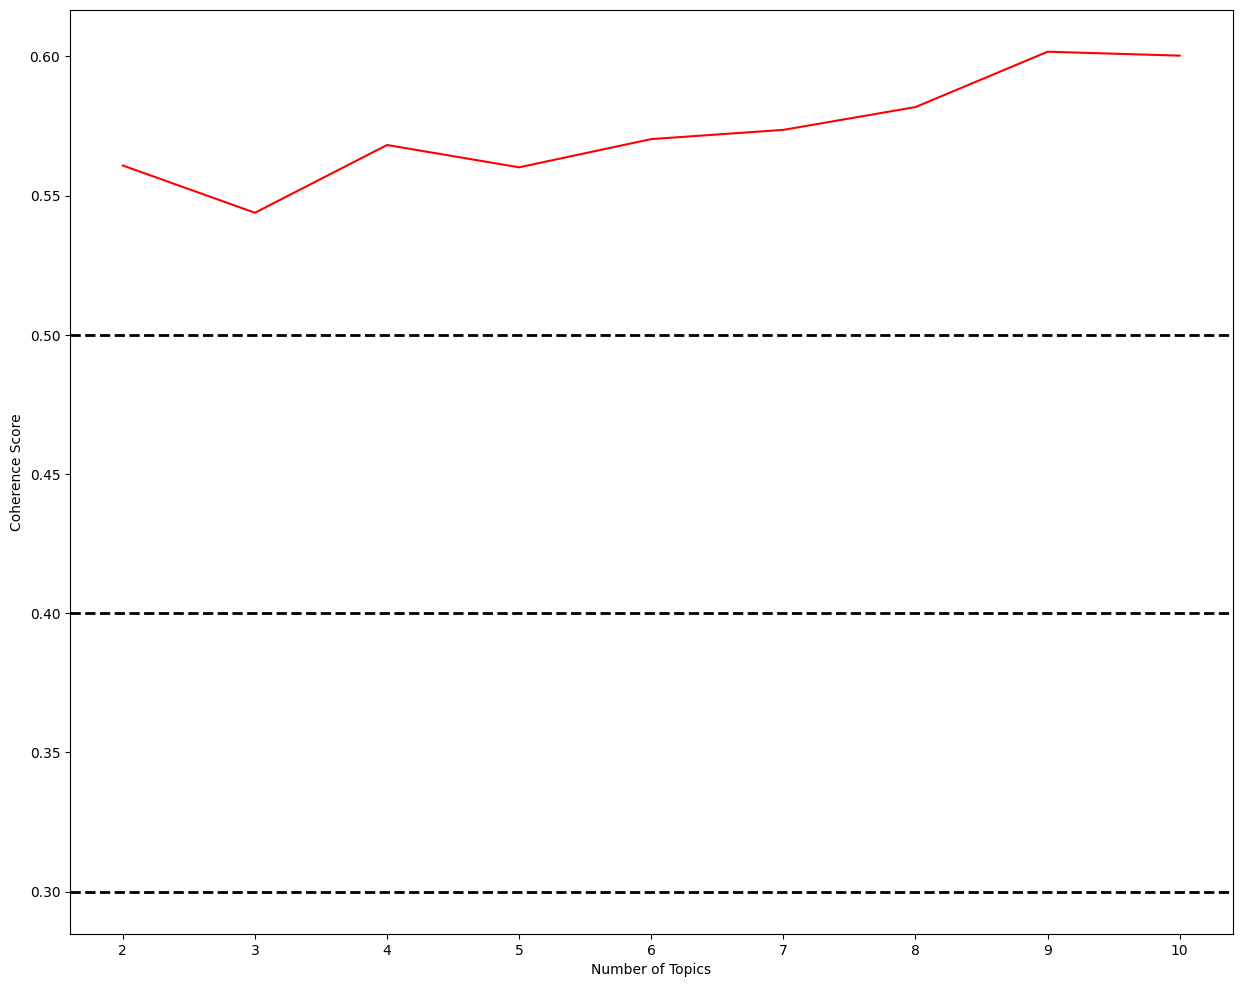

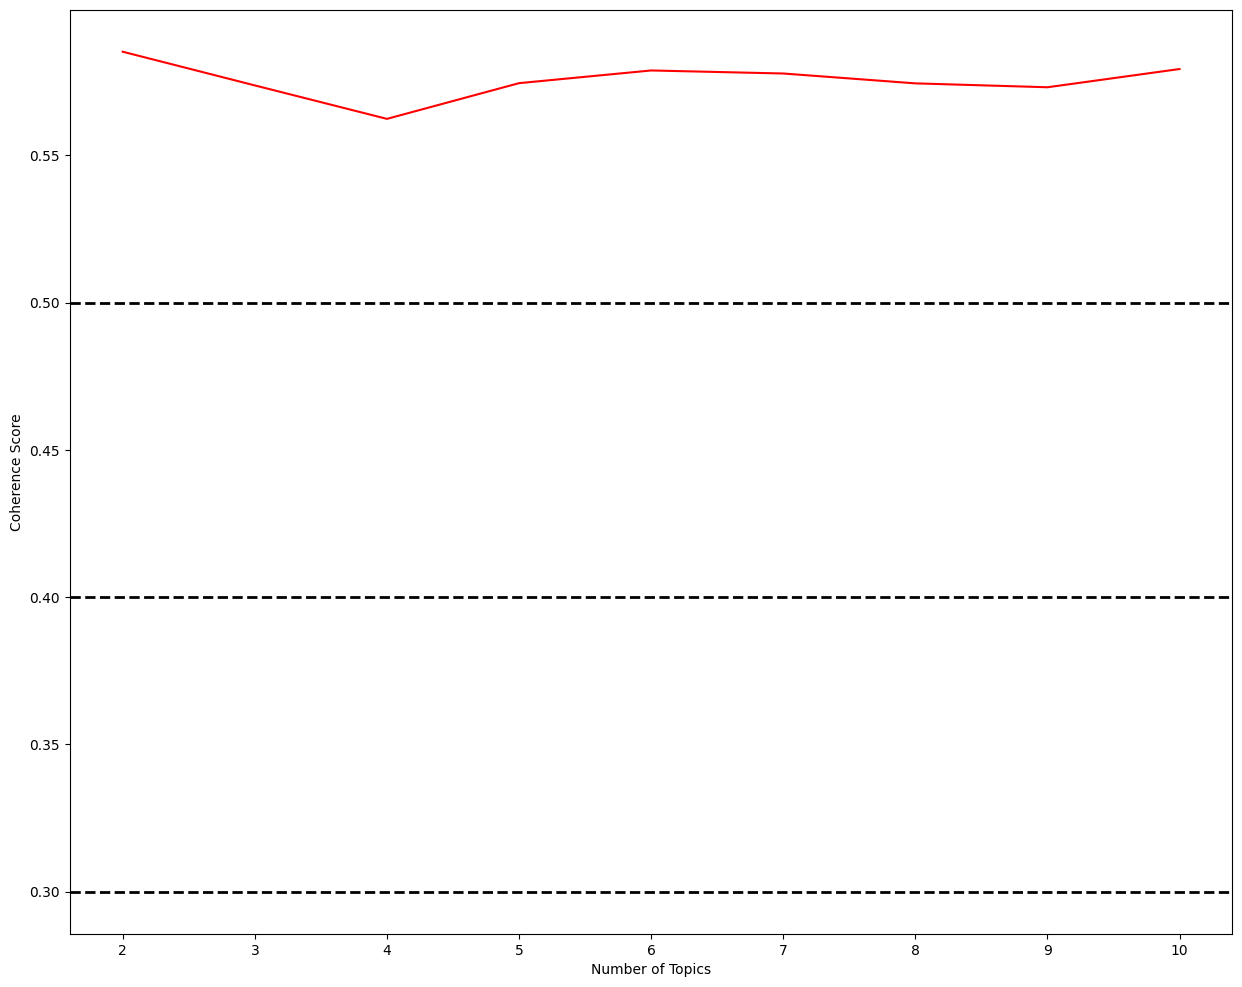


DF NAME: df_neg



  0%|                                                                                            | 0/9 [00:00<?, ?it/s]


MODEL: LSI - NUMBER OF TOPICS: 2


 11%|█████████▎                                                                          | 1/9 [00:44<05:58, 44.79s/it]

Topic #1:
0.713*"I" + 0.415*"room" + 0.272*"hotel" + 0.141*"staff" + 0.137*"check" + 0.132*"stay" + 0.091*"get" + 0.082*"night" + 0.081*"book" + 0.076*"bed" + 0.074*"one" + 0.074*"time" + 0.072*"day" + 0.070*"ask" + 0.070*"clean" + 0.062*"go" + 0.062*"even" + 0.062*"small" + 0.059*"good" + 0.057*"pay"

Topic #2:
0.709*"room" + -0.606*"I" + 0.120*"small" + 0.105*"hotel" + 0.093*"bed" + 0.077*"clean" + 0.075*"get" + 0.070*"good" + 0.061*"bathroom" + 0.057*"smell" + 0.056*"toilet" + 0.051*"water" + 0.048*"book" + 0.048*"location" + 0.047*"shower" + 0.044*"well" + 0.042*"bad" + 0.042*"old" + 0.040*"night" + 0.040*"staff"

--------------------------------------------------

MODEL: LSI - NUMBER OF TOPICS: 3


 22%|██████████████████▋                                                                 | 2/9 [01:32<05:24, 46.35s/it]

Topic #1:
0.713*"I" + 0.415*"room" + 0.272*"hotel" + 0.141*"staff" + 0.137*"check" + 0.131*"stay" + 0.091*"get" + 0.082*"night" + 0.081*"book" + 0.075*"bed" + 0.074*"one" + 0.074*"time" + 0.072*"day" + 0.070*"ask" + 0.070*"clean" + 0.062*"go" + 0.062*"even" + 0.061*"small" + 0.059*"good" + 0.057*"pay"

Topic #2:
0.716*"room" + -0.600*"I" + 0.121*"small" + 0.097*"bed" + 0.086*"hotel" + 0.078*"clean" + 0.074*"get" + 0.069*"good" + 0.063*"bathroom" + 0.058*"smell" + 0.057*"toilet" + 0.051*"water" + 0.049*"location" + 0.048*"shower" + 0.047*"book" + 0.043*"well" + 0.042*"door" + 0.041*"old" + 0.041*"dirty" + 0.040*"night"

Topic #3:
0.805*"hotel" + -0.365*"room" + -0.255*"I" + 0.205*"staff" + 0.096*"breakfast" + 0.086*"stay" + 0.066*"time" + 0.063*"guest" + 0.062*"good" + 0.062*"day" + 0.059*"check" + 0.056*"service" + 0.054*"star" + 0.053*"location" + 0.051*"get" + 0.049*"well" + -0.049*"bed" + 0.043*"say" + 0.043*"price" + -0.042*"small"

-------------------------------------------------

 33%|████████████████████████████                                                        | 3/9 [02:18<04:36, 46.16s/it]

Topic #1:
0.713*"I" + 0.415*"room" + 0.272*"hotel" + 0.141*"staff" + 0.137*"check" + 0.131*"stay" + 0.091*"get" + 0.082*"night" + 0.081*"book" + 0.076*"bed" + 0.074*"one" + 0.074*"time" + 0.072*"day" + 0.070*"ask" + 0.070*"clean" + 0.062*"go" + 0.062*"even" + 0.061*"small" + 0.059*"good" + 0.057*"pay"

Topic #2:
0.716*"room" + -0.602*"I" + 0.122*"small" + 0.094*"hotel" + 0.093*"bed" + 0.076*"clean" + 0.074*"get" + 0.069*"good" + 0.059*"bathroom" + 0.057*"smell" + 0.056*"toilet" + 0.051*"water" + 0.048*"book" + 0.046*"shower" + 0.046*"location" + 0.042*"well" + 0.042*"old" + 0.040*"dirty" + 0.040*"night" + 0.040*"towel"

Topic #3:
0.811*"hotel" + -0.360*"room" + -0.250*"I" + 0.199*"staff" + 0.098*"breakfast" + 0.083*"stay" + 0.065*"day" + 0.064*"time" + 0.064*"guest" + -0.063*"bed" + 0.061*"check" + 0.060*"good" + 0.055*"star" + 0.052*"service" + 0.047*"get" + 0.043*"well" + 0.042*"location" + 0.042*"price" + 0.042*"say" + 0.040*"go"

Topic #4:
-0.356*"room" + 0.314*"bed" + -0.302*"hote

 44%|█████████████████████████████████████▎                                              | 4/9 [03:04<03:51, 46.32s/it]

Topic #1:
0.713*"I" + 0.415*"room" + 0.272*"hotel" + 0.141*"staff" + 0.136*"check" + 0.131*"stay" + 0.091*"get" + 0.082*"night" + 0.081*"book" + 0.076*"bed" + 0.074*"one" + 0.074*"time" + 0.072*"day" + 0.070*"ask" + 0.070*"clean" + 0.062*"go" + 0.062*"even" + 0.062*"small" + 0.059*"good" + 0.057*"pay"

Topic #2:
0.716*"room" + -0.602*"I" + 0.122*"small" + 0.095*"hotel" + 0.093*"bed" + 0.076*"clean" + 0.073*"get" + 0.069*"good" + 0.059*"bathroom" + 0.057*"smell" + 0.056*"toilet" + 0.051*"water" + 0.048*"book" + 0.046*"shower" + 0.046*"location" + 0.042*"old" + 0.042*"well" + 0.040*"dirty" + 0.040*"night" + 0.039*"towel"

Topic #3:
0.826*"hotel" + -0.358*"room" + -0.243*"I" + 0.178*"staff" + 0.095*"breakfast" + 0.072*"stay" + 0.062*"guest" + 0.061*"good" + 0.057*"time" + 0.056*"day" + 0.055*"star" + -0.052*"bed" + 0.048*"service" + 0.047*"check" + 0.046*"get" + 0.044*"location" + 0.043*"price" + 0.041*"well" + 0.041*"say" + 0.036*"singapore"

Topic #4:
-0.357*"room" + 0.310*"stay" + -0.3

 56%|██████████████████████████████████████████████▋                                     | 5/9 [03:51<03:06, 46.58s/it]

Topic #1:
0.713*"I" + 0.415*"room" + 0.272*"hotel" + 0.141*"staff" + 0.136*"check" + 0.131*"stay" + 0.091*"get" + 0.082*"night" + 0.081*"book" + 0.076*"bed" + 0.074*"one" + 0.074*"time" + 0.072*"day" + 0.070*"clean" + 0.070*"ask" + 0.062*"go" + 0.062*"small" + 0.062*"even" + 0.059*"good" + 0.057*"pay"

Topic #2:
0.716*"room" + -0.602*"I" + 0.121*"small" + 0.095*"hotel" + 0.093*"bed" + 0.076*"clean" + 0.074*"get" + 0.069*"good" + 0.059*"bathroom" + 0.057*"smell" + 0.056*"toilet" + 0.051*"water" + 0.048*"book" + 0.046*"shower" + 0.046*"location" + 0.042*"old" + 0.042*"well" + 0.041*"night" + 0.040*"dirty" + 0.040*"towel"

Topic #3:
0.826*"hotel" + -0.359*"room" + -0.244*"I" + 0.171*"staff" + 0.095*"breakfast" + 0.071*"stay" + 0.062*"guest" + 0.060*"good" + 0.059*"day" + 0.058*"time" + 0.055*"star" + 0.053*"check" + -0.050*"bed" + 0.049*"get" + 0.048*"service" + 0.044*"location" + 0.043*"price" + 0.041*"well" + 0.040*"say" + 0.037*"singapore"

Topic #4:
-0.357*"room" + 0.309*"stay" + -0.3

 67%|████████████████████████████████████████████████████████                            | 6/9 [04:39<02:20, 46.96s/it]

Topic #1:
0.713*"I" + 0.415*"room" + 0.272*"hotel" + 0.141*"staff" + 0.136*"check" + 0.131*"stay" + 0.091*"get" + 0.082*"night" + 0.081*"book" + 0.076*"bed" + 0.074*"one" + 0.074*"time" + 0.072*"day" + 0.070*"ask" + 0.070*"clean" + 0.062*"go" + 0.062*"even" + 0.062*"small" + 0.059*"good" + 0.057*"pay"

Topic #2:
0.715*"room" + -0.602*"I" + 0.122*"small" + 0.096*"hotel" + 0.094*"bed" + 0.077*"clean" + 0.074*"get" + 0.069*"good" + 0.059*"bathroom" + 0.057*"smell" + 0.056*"toilet" + 0.051*"water" + 0.048*"book" + 0.047*"shower" + 0.046*"location" + 0.042*"old" + 0.042*"night" + 0.042*"well" + 0.040*"dirty" + 0.040*"towel"

Topic #3:
0.826*"hotel" + -0.359*"room" + -0.243*"I" + 0.169*"staff" + 0.095*"breakfast" + 0.075*"stay" + 0.063*"guest" + 0.061*"good" + 0.060*"day" + 0.058*"time" + 0.055*"star" + -0.051*"bed" + 0.049*"get" + 0.048*"check" + 0.048*"service" + 0.044*"location" + 0.043*"price" + 0.041*"well" + 0.040*"say" + 0.037*"singapore"

Topic #4:
-0.358*"room" + 0.312*"stay" + 0.31

 78%|█████████████████████████████████████████████████████████████████▎                  | 7/9 [05:27<01:34, 47.39s/it]

Topic #1:
0.713*"I" + 0.415*"room" + 0.272*"hotel" + 0.141*"staff" + 0.136*"check" + 0.131*"stay" + 0.091*"get" + 0.082*"night" + 0.081*"book" + 0.076*"bed" + 0.074*"one" + 0.074*"time" + 0.072*"day" + 0.070*"ask" + 0.070*"clean" + 0.062*"go" + 0.062*"even" + 0.062*"small" + 0.059*"good" + 0.057*"pay"

Topic #2:
0.715*"room" + -0.602*"I" + 0.123*"small" + 0.096*"hotel" + 0.093*"bed" + 0.077*"clean" + 0.074*"get" + 0.069*"good" + 0.059*"bathroom" + 0.057*"smell" + 0.056*"toilet" + 0.051*"water" + 0.047*"book" + 0.047*"shower" + 0.046*"location" + 0.042*"old" + 0.042*"night" + 0.042*"well" + 0.040*"towel" + 0.040*"dirty"

Topic #3:
0.827*"hotel" + -0.359*"room" + -0.243*"I" + 0.168*"staff" + 0.095*"breakfast" + 0.075*"stay" + 0.063*"guest" + 0.061*"good" + 0.060*"day" + 0.058*"time" + 0.055*"star" + -0.051*"bed" + 0.049*"get" + 0.048*"check" + 0.048*"service" + 0.044*"location" + 0.043*"price" + 0.041*"well" + 0.040*"say" + 0.037*"singapore"

Topic #4:
-0.358*"room" + 0.312*"bed" + 0.309

 89%|██████████████████████████████████████████████████████████████████████████▋         | 8/9 [06:16<00:47, 47.84s/it]

Topic #1:
0.713*"I" + 0.415*"room" + 0.272*"hotel" + 0.141*"staff" + 0.136*"check" + 0.131*"stay" + 0.091*"get" + 0.082*"night" + 0.081*"book" + 0.076*"bed" + 0.074*"one" + 0.074*"time" + 0.072*"day" + 0.070*"ask" + 0.070*"clean" + 0.062*"go" + 0.062*"even" + 0.062*"small" + 0.059*"good" + 0.057*"pay"

Topic #2:
0.715*"room" + -0.602*"I" + 0.123*"small" + 0.096*"hotel" + 0.094*"bed" + 0.077*"clean" + 0.074*"get" + 0.070*"good" + 0.059*"bathroom" + 0.057*"smell" + 0.056*"toilet" + 0.051*"water" + 0.048*"book" + 0.047*"shower" + 0.046*"location" + 0.042*"old" + 0.042*"night" + 0.042*"well" + 0.040*"towel" + 0.040*"dirty"

Topic #3:
0.826*"hotel" + -0.360*"room" + -0.244*"I" + 0.171*"staff" + 0.095*"breakfast" + 0.073*"stay" + 0.063*"guest" + 0.060*"good" + 0.060*"day" + 0.058*"time" + 0.055*"star" + 0.050*"get" + -0.049*"bed" + 0.049*"check" + 0.049*"service" + 0.043*"price" + 0.043*"location" + 0.041*"well" + 0.040*"say" + 0.036*"singapore"

Topic #4:
-0.360*"room" + 0.319*"bed" + 0.302

100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [07:05<00:00, 47.32s/it]


Topic #1:
0.713*"I" + 0.415*"room" + 0.272*"hotel" + 0.141*"staff" + 0.136*"check" + 0.131*"stay" + 0.091*"get" + 0.082*"night" + 0.081*"book" + 0.076*"bed" + 0.074*"one" + 0.074*"time" + 0.072*"day" + 0.070*"ask" + 0.070*"clean" + 0.062*"go" + 0.062*"even" + 0.062*"small" + 0.059*"good" + 0.057*"pay"

Topic #2:
0.715*"room" + -0.602*"I" + 0.122*"small" + 0.096*"hotel" + 0.093*"bed" + 0.077*"clean" + 0.074*"get" + 0.070*"good" + 0.059*"bathroom" + 0.058*"smell" + 0.056*"toilet" + 0.052*"water" + 0.047*"book" + 0.047*"shower" + 0.046*"location" + 0.042*"old" + 0.042*"well" + 0.042*"night" + 0.040*"towel" + 0.040*"dirty"

Topic #3:
0.825*"hotel" + -0.359*"room" + -0.244*"I" + 0.178*"staff" + 0.093*"breakfast" + 0.076*"stay" + 0.066*"guest" + 0.059*"good" + 0.059*"time" + 0.056*"day" + 0.054*"star" + -0.053*"bed" + 0.049*"check" + 0.048*"service" + 0.048*"get" + 0.042*"location" + -0.041*"small" + 0.041*"price" + 0.041*"well" + 0.039*"say"

Topic #4:
-0.359*"room" + 0.321*"bed" + 0.305*"s

  0%|                                                                                            | 0/9 [00:00<?, ?it/s]


MODEL: LDA - NUMBER OF TOPICS: 2


 11%|█████████▎                                                                          | 1/9 [00:05<00:41,  5.19s/it]

Topic #1:
0.063*"I" + 0.062*"room" + 0.023*"hotel" + 0.017*"staff" + 0.014*"get" + 0.013*"bed" + 0.011*"stay" + 0.011*"check" + 0.010*"night" + 0.010*"even" + 0.010*"small" + 0.010*"book" + 0.010*"time" + 0.009*"clean" + 0.008*"one" + 0.008*"day" + 0.008*"nothing" + 0.008*"bathroom" + 0.008*"would" + 0.007*"good"

Topic #2:
0.046*"room" + 0.042*"hotel" + 0.021*"I" + 0.019*"stay" + 0.016*"small" + 0.014*"good" + 0.013*"staff" + 0.013*"clean" + 0.012*"toilet" + 0.012*"dirty" + 0.012*"smell" + 0.011*"location" + 0.011*"check" + 0.009*"need" + 0.009*"breakfast" + 0.009*"time" + 0.008*"like" + 0.008*"night" + 0.008*"bed" + 0.008*"bathroom"

--------------------------------------------------

MODEL: LDA - NUMBER OF TOPICS: 3


 22%|██████████████████▋                                                                 | 2/9 [00:09<00:33,  4.76s/it]

Topic #1:
0.038*"I" + 0.034*"room" + 0.028*"nothing" + 0.023*"hotel" + 0.020*"bed" + 0.020*"staff" + 0.017*"small" + 0.013*"toilet" + 0.013*"dirty" + 0.012*"smell" + 0.010*"would" + 0.010*"charge" + 0.010*"bathroom" + 0.010*"shower" + 0.009*"even" + 0.009*"like" + 0.009*"breakfast" + 0.008*"stay" + 0.008*"night" + 0.008*"water"

Topic #2:
0.039*"I" + 0.035*"room" + 0.033*"hotel" + 0.020*"bed" + 0.018*"stay" + 0.016*"bit" + 0.015*"location" + 0.015*"staff" + 0.012*"good" + 0.012*"could" + 0.012*"breakfast" + 0.011*"would" + 0.011*"need" + 0.010*"well" + 0.009*"like" + 0.009*"small" + 0.009*"place" + 0.008*"even" + 0.008*"water" + 0.008*"old"

Topic #3:
0.068*"room" + 0.051*"I" + 0.032*"hotel" + 0.015*"stay" + 0.014*"staff" + 0.013*"check" + 0.013*"get" + 0.012*"small" + 0.012*"clean" + 0.011*"time" + 0.011*"good" + 0.010*"night" + 0.009*"one" + 0.009*"day" + 0.009*"bathroom" + 0.008*"book" + 0.008*"go" + 0.007*"bad" + 0.007*"service" + 0.007*"need"

-------------------------------------

 33%|████████████████████████████                                                        | 3/9 [00:14<00:27,  4.58s/it]

Topic #1:
0.047*"room" + 0.037*"hotel" + 0.025*"get" + 0.020*"small" + 0.020*"good" + 0.020*"I" + 0.017*"water" + 0.014*"check" + 0.013*"staff" + 0.013*"stay" + 0.013*"bathroom" + 0.013*"shower" + 0.012*"toilet" + 0.012*"time" + 0.012*"one" + 0.010*"well" + 0.010*"day" + 0.009*"location" + 0.009*"around" + 0.008*"god"

Topic #2:
0.066*"room" + 0.045*"hotel" + 0.041*"I" + 0.018*"small" + 0.016*"breakfast" + 0.014*"work" + 0.013*"staff" + 0.013*"smell" + 0.011*"price" + 0.010*"dirty" + 0.010*"like" + 0.010*"could" + 0.010*"time" + 0.010*"would" + 0.009*"need" + 0.009*"stay" + 0.008*"check" + 0.008*"bad" + 0.008*"get" + 0.007*"go"

Topic #3:
0.030*"room" + 0.029*"I" + 0.027*"bed" + 0.025*"stay" + 0.019*"hotel" + 0.018*"night" + 0.017*"small" + 0.015*"bathroom" + 0.015*"staff" + 0.014*"toilet" + 0.014*"shower" + 0.013*"clean" + 0.013*"old" + 0.011*"area" + 0.010*"location" + 0.010*"need" + 0.010*"bad" + 0.009*"would" + 0.008*"price" + 0.008*"bit"

Topic #4:
0.063*"I" + 0.062*"room" + 0.025

 44%|█████████████████████████████████████▎                                              | 4/9 [00:18<00:22,  4.45s/it]

Topic #1:
0.040*"room" + 0.035*"hotel" + 0.023*"nothing" + 0.020*"I" + 0.019*"clean" + 0.018*"stay" + 0.017*"breakfast" + 0.016*"staff" + 0.015*"night" + 0.013*"time" + 0.013*"good" + 0.013*"get" + 0.012*"one" + 0.012*"service" + 0.011*"well" + 0.011*"door" + 0.010*"need" + 0.009*"work" + 0.009*"even" + 0.009*"dirty"

Topic #2:
0.058*"I" + 0.043*"room" + 0.034*"hotel" + 0.031*"staff" + 0.030*"check" + 0.013*"stay" + 0.013*"bad" + 0.013*"good" + 0.011*"reception" + 0.011*"get" + 0.010*"even" + 0.009*"go" + 0.009*"book" + 0.009*"could" + 0.009*"location" + 0.009*"give" + 0.009*"pm" + 0.009*"time" + 0.007*"one" + 0.007*"experience"

Topic #3:
0.062*"I" + 0.043*"room" + 0.022*"stay" + 0.018*"bed" + 0.018*"night" + 0.016*"like" + 0.014*"hotel" + 0.013*"place" + 0.012*"get" + 0.011*"never" + 0.011*"book" + 0.011*"one" + 0.010*"pay" + 0.010*"would" + 0.010*"expensive" + 0.009*"thing" + 0.009*"see" + 0.009*"tiny" + 0.009*"small" + 0.008*"bathroom"

Topic #4:
0.101*"room" + 0.046*"small" + 0.02

 56%|██████████████████████████████████████████████▋                                     | 5/9 [00:22<00:17,  4.32s/it]

Topic #1:
0.089*"room" + 0.032*"I" + 0.026*"small" + 0.021*"hotel" + 0.017*"clean" + 0.016*"staff" + 0.013*"stay" + 0.013*"time" + 0.013*"get" + 0.011*"good" + 0.011*"well" + 0.010*"bathroom" + 0.010*"need" + 0.009*"work" + 0.009*"go" + 0.008*"bed" + 0.008*"shower" + 0.008*"breakfast" + 0.008*"location" + 0.008*"even"

Topic #2:
0.062*"room" + 0.033*"I" + 0.026*"water" + 0.024*"toilet" + 0.022*"bed" + 0.020*"hotel" + 0.020*"bathroom" + 0.016*"smell" + 0.015*"shower" + 0.015*"small" + 0.012*"night" + 0.012*"need" + 0.011*"bad" + 0.010*"old" + 0.010*"get" + 0.010*"floor" + 0.010*"stay" + 0.008*"bit" + 0.008*"clean" + 0.008*"noisy"

Topic #3:
0.077*"I" + 0.041*"room" + 0.026*"check" + 0.024*"hotel" + 0.017*"stay" + 0.016*"staff" + 0.015*"door" + 0.013*"bed" + 0.013*"night" + 0.011*"pm" + 0.011*"time" + 0.010*"one" + 0.009*"book" + 0.009*"give" + 0.009*"could" + 0.008*"even" + 0.008*"get" + 0.008*"sleep" + 0.008*"next" + 0.008*"morning"

Topic #4:
0.066*"hotel" + 0.065*"I" + 0.028*"stay" +

 67%|████████████████████████████████████████████████████████                            | 6/9 [00:26<00:12,  4.28s/it]

Topic #1:
0.075*"room" + 0.058*"nothing" + 0.033*"small" + 0.029*"bathroom" + 0.021*"hotel" + 0.020*"price" + 0.020*"expensive" + 0.019*"get" + 0.017*"well" + 0.014*"breakfast" + 0.014*"bad" + 0.013*"bit" + 0.013*"stay" + 0.012*"dirty" + 0.011*"good" + 0.011*"high" + 0.011*"staff" + 0.010*"I" + 0.010*"smell" + 0.010*"air_condition"

Topic #2:
0.092*"I" + 0.040*"hotel" + 0.026*"staff" + 0.024*"room" + 0.023*"check" + 0.018*"stay" + 0.014*"even" + 0.014*"book" + 0.013*"bed" + 0.013*"pm" + 0.010*"get" + 0.010*"pay" + 0.010*"reception" + 0.009*"day" + 0.009*"night" + 0.008*"would" + 0.008*"time" + 0.008*"around" + 0.007*"take" + 0.007*"guest"

Topic #3:
0.063*"room" + 0.045*"hotel" + 0.022*"bed" + 0.021*"small" + 0.020*"get" + 0.016*"book" + 0.013*"good" + 0.013*"floor" + 0.012*"location" + 0.012*"staff" + 0.011*"breakfast" + 0.010*"bad" + 0.010*"stay" + 0.010*"dirty" + 0.009*"experience" + 0.009*"one" + 0.009*"restaurant" + 0.009*"I" + 0.008*"option" + 0.008*"old"

Topic #4:
0.058*"I" + 0

 78%|█████████████████████████████████████████████████████████████████▎                  | 7/9 [00:30<00:08,  4.20s/it]

Topic #1:
0.040*"room" + 0.026*"I" + 0.022*"bathroom" + 0.022*"shower" + 0.020*"hotel" + 0.020*"toilet" + 0.019*"staff" + 0.018*"small" + 0.017*"clean" + 0.016*"bad" + 0.013*"like" + 0.012*"get" + 0.011*"door" + 0.011*"smell" + 0.011*"need" + 0.010*"stay" + 0.010*"place" + 0.010*"well" + 0.010*"water" + 0.009*"make"

Topic #2:
0.052*"room" + 0.036*"hotel" + 0.025*"I" + 0.018*"location" + 0.016*"get" + 0.015*"one" + 0.015*"clean" + 0.015*"bathroom" + 0.014*"good" + 0.014*"bed" + 0.014*"noise" + 0.012*"old" + 0.012*"work" + 0.011*"night" + 0.011*"reception" + 0.011*"go" + 0.011*"bit" + 0.010*"check" + 0.010*"staff" + 0.010*"small"

Topic #3:
0.063*"room" + 0.050*"I" + 0.050*"hotel" + 0.026*"check" + 0.020*"stay" + 0.018*"staff" + 0.015*"book" + 0.013*"even" + 0.011*"get" + 0.011*"night" + 0.011*"would" + 0.010*"take" + 0.010*"go" + 0.009*"good" + 0.009*"small" + 0.009*"time" + 0.008*"day" + 0.008*"one" + 0.008*"ask" + 0.008*"like"

Topic #4:
0.116*"I" + 0.039*"hotel" + 0.025*"staff" + 0.

 89%|██████████████████████████████████████████████████████████████████████████▋         | 8/9 [00:34<00:04,  4.18s/it]

Topic #1:
0.077*"I" + 0.067*"room" + 0.029*"hotel" + 0.022*"nothing" + 0.015*"clean" + 0.014*"staff" + 0.014*"check" + 0.012*"bad" + 0.011*"night" + 0.011*"get" + 0.011*"door" + 0.010*"go" + 0.010*"even" + 0.010*"like" + 0.009*"reception" + 0.009*"pay" + 0.009*"change" + 0.009*"bed" + 0.008*"want" + 0.008*"sleep"

Topic #2:
0.064*"I" + 0.058*"hotel" + 0.032*"room" + 0.024*"stay" + 0.020*"staff" + 0.017*"check" + 0.017*"one" + 0.017*"time" + 0.013*"get" + 0.012*"night" + 0.010*"good" + 0.008*"ask" + 0.008*"service" + 0.008*"bit" + 0.008*"breakfast" + 0.008*"reception" + 0.008*"rude" + 0.008*"even" + 0.008*"look" + 0.008*"pay"

Topic #3:
0.055*"I" + 0.032*"hotel" + 0.024*"place" + 0.020*"staff" + 0.020*"breakfast" + 0.016*"room" + 0.012*"like" + 0.012*"would" + 0.012*"guest" + 0.012*"check" + 0.011*"bottle" + 0.011*"location" + 0.011*"even" + 0.010*"service" + 0.010*"make" + 0.009*"feel" + 0.009*"walk" + 0.009*"water" + 0.009*"use" + 0.009*"stay"

Topic #4:
0.032*"toilet" + 0.031*"bad" +

100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:38<00:00,  4.31s/it]

Topic #1:
0.050*"room" + 0.040*"hotel" + 0.031*"I" + 0.022*"staff" + 0.017*"stay" + 0.016*"go" + 0.015*"one" + 0.014*"like" + 0.013*"get" + 0.012*"bed" + 0.012*"breakfast" + 0.011*"night" + 0.011*"toilet" + 0.011*"place" + 0.011*"door" + 0.010*"old" + 0.010*"look" + 0.010*"check" + 0.009*"smell" + 0.009*"even"

Topic #2:
0.029*"I" + 0.023*"like" + 0.022*"room" + 0.021*"location" + 0.021*"door" + 0.020*"sleep" + 0.019*"stay" + 0.019*"provide" + 0.019*"hotel" + 0.014*"time" + 0.014*"staff" + 0.014*"even" + 0.013*"check" + 0.012*"great" + 0.012*"water" + 0.011*"need" + 0.011*"bathroom" + 0.011*"guest" + 0.011*"give" + 0.010*"noise"

Topic #3:
0.062*"room" + 0.037*"good" + 0.033*"hotel" + 0.023*"book" + 0.017*"get" + 0.017*"even" + 0.015*"time" + 0.014*"well" + 0.013*"stay" + 0.012*"I" + 0.012*"service" + 0.011*"old" + 0.010*"price" + 0.010*"location" + 0.010*"much" + 0.010*"god" + 0.010*"work" + 0.010*"worth" + 0.009*"first" + 0.009*"option"

Topic #4:
0.071*"I" + 0.047*"staff" + 0.031*"h

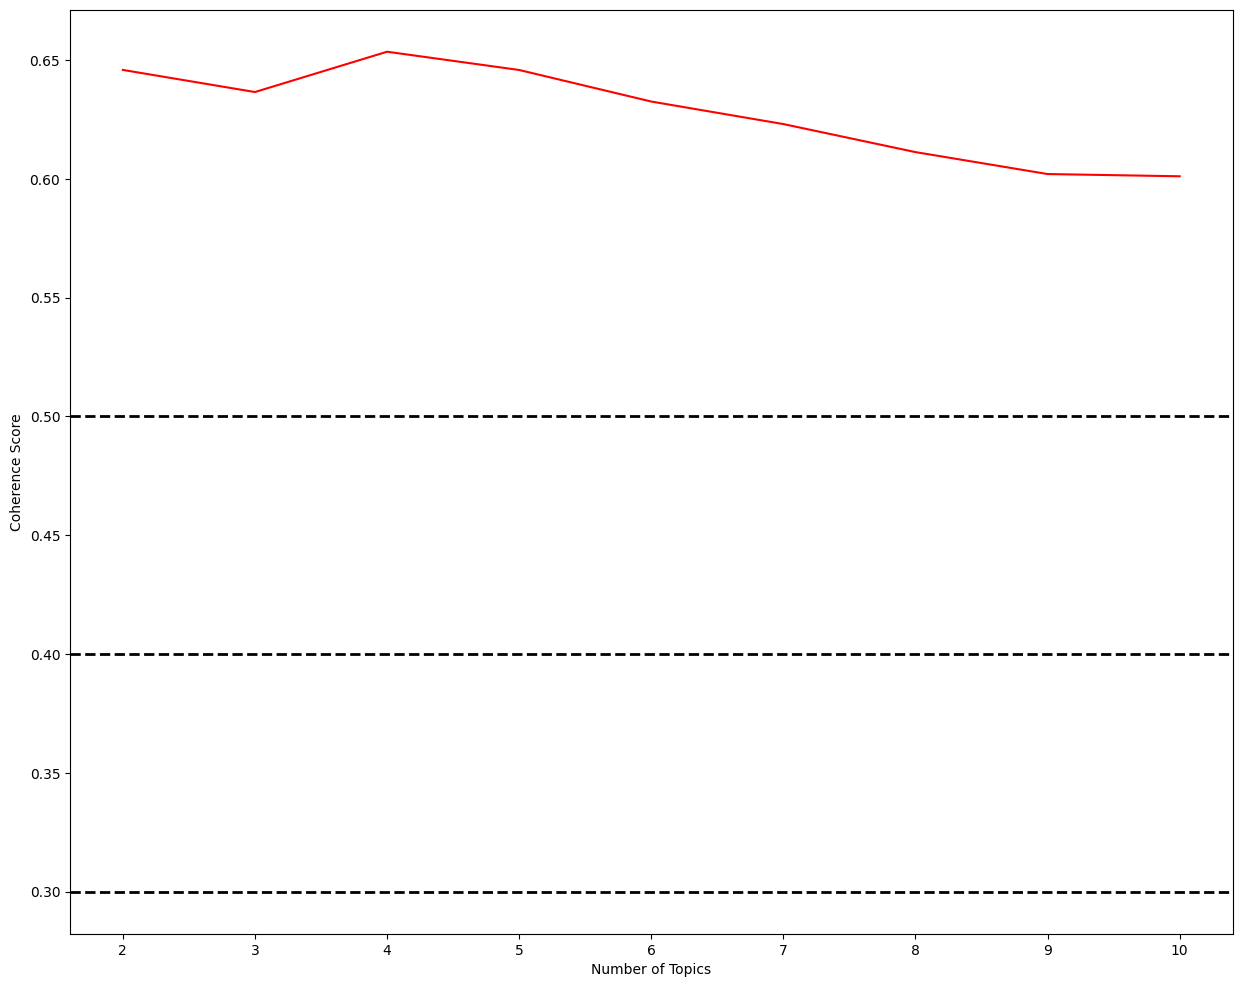

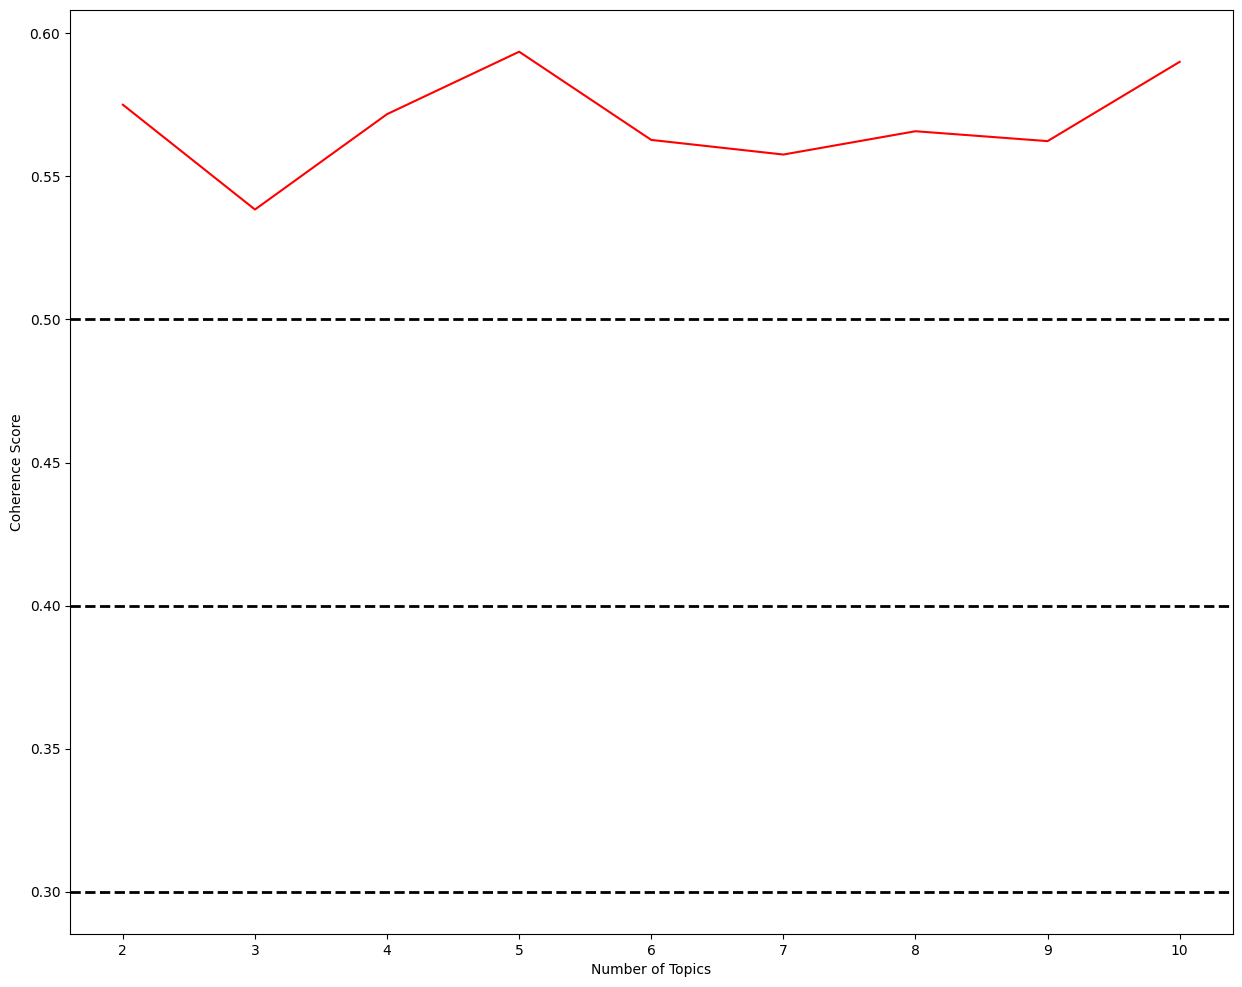

In [10]:
# Calculate coherence scores for each model
target_text = "review_cleaned_v1"

overall_coherence_df = pd.DataFrame() # df to store coherence_df
model_topic_info_list = []  # List to store model_topic_info

for i, df_set in enumerate(df_sets):
    
    print("\nDF NAME: {}\n".format(df_names[i]))

    coherence_df, model_topic_info = topic_model_coherence_plot(df_set, df_names[i], target_text, MODEL_NAMES, START_TOPIC_COUNT, END_TOPIC_COUNT)
    overall_coherence_df = pd.concat([overall_coherence_df, coherence_df], axis=0) # Concatenate to overall_coherence_df
    model_topic_info_list.append(model_topic_info) # Store model_topic_info in a list

In [11]:
# Print all models' coherence scores
overall_coherence_df

,Model Name,Number of Topics,Coherence Score,df_name
0,LSI,2,0.560771,df_pos
1,LSI,3,0.543809,df_pos
2,LSI,4,0.568139,df_pos
3,LSI,5,0.560127,df_pos
4,LSI,6,0.570258,df_pos
5,LSI,7,0.573572,df_pos
6,LSI,8,0.581759,df_pos
7,LSI,9,0.601634,df_pos
8,LSI,10,0.600230,df_pos
0,LDA,2,0.585127,df_pos


In [12]:
# Store coherence scores of all models into "overall_coherence_df", sort by "df_name" and "Coherence Score"
overall_coherence_df = overall_coherence_df.sort_values(["df_name", "Coherence Score"], ascending=False).reset_index(drop=True)
#overall_coherence_df

# Find best model for each df
overall_coherence_best_df = overall_coherence_df.loc[overall_coherence_df.groupby("df_name")["Coherence Score"].idxmax()].reset_index(drop=True)
overall_coherence_best_df

,Model Name,Number of Topics,Coherence Score,df_name
0,LSI,4,0.653467,df_neg
1,LSI,9,0.601634,df_pos


In [13]:
# Print topics of best model
print_best_model_topics(overall_coherence_best_df, model_topic_info_list)


DF NAME: df_neg
MODEL: LSI - NUMBER OF TOPICS: 4

Topic 1: I, room, hotel, staff, check, stay, get, night, book, bed

Topic 2: room, I, small, hotel, bed, clean, get, good, bathroom, smell

Topic 3: hotel, room, I, staff, breakfast, stay, day, time, guest, bed

Topic 4: room, bed, hotel, stay, clean, door, get, shower, bathroom, night

----------


DF NAME: df_pos
MODEL: LSI - NUMBER OF TOPICS: 9

Topic 1: I, room, hotel, stay, staff, good, location, clean, check, get

Topic 2: I, room, good, location, hotel, clean, great, small, staff, nice

Topic 3: room, hotel, good, location, staff, stay, great, small, friendly, place

Topic 4: hotel, good, location, staff, room, place, great, I, stay, friendly

Topic 5: good, staff, stay, great, friendly, hotel, helpful, clean, I, nice

Topic 6: stay, staff, friendly, clean, helpful, place, night, check, would, hotel

Topic 7: location, great, good, staff, stay, near, meet, I, check, friendly

Topic 8: clean, place, location, great, near, room, n

In [14]:
end_time = datetime.now()
print("Text processing ended at {}".format(end_time))
print("Text processing spent {}".format(end_time - start_time))

Text processing ended at 2024-06-26 21:26:27.993998
Text processing spent 0:35:40.554904
